In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
#import shapefile
import geopandas as gp
import yaml
import math
#from pykml import parser


/tmp/ipykernel_1787/2191088606.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_image = dir_project + info_basic['rdir_image']+'phase/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
dir_disp = dir_project + info_basic['rdir_disp_model']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['264--12-10',
 '536--49-16',
 '63--47-04',
 '493--38-15',
 '338--46-11',
 '249--40-09',
 '210--45-08',
 '41--10-04',
 '540--07-17',
 '184--18-08',
 '411--30-13',
 '201--36-08',
 '406--25-13',
 '324--32-11',
 '15--23-03',
 '572--09-18',
 '307--08-11',
 '476--08-15',
 '55--31-04',
 '113--25-06',
 '175--51-07',
 '169--45-07',
 '385--49-12',
 '9--16-03',
 '218--53-08',
 '512--09-16',
 '183--17-08',
 '272--21-10',
 '545--13-17',
 '535--48-16',
 '56--32-04',
 '337--45-11',
 '89--40-05',
 '489--34-15',
 '575--12-18',
 '277--26-10',
 '556--35-17',
 '65--49-04',
 '10--18-03',
 '593--50-18',
 '199--34-08',
 '367--31-12',
 '390--54-12',
 '282--31-10',
 '204--39-08',
 '461--41-14',
 '423--42-13',
 '157--32-07',
 '392--09-13',
 '332--40-11',
 '442--18-14',
 '357--20-12',
 '353--15-12',
 '372--36-12',
 '233--24-09',
 '248--39-09',
 '531--44-16',
 '284--33-10',
 '191--25-08',
 '510--07-16',
 '568--53-17',
 '217--52-08',
 '36--52-03',
 '44--17-04',
 '521--34-16',
 '105--14-06',
 '437--08-14',
 '93--4

In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

In [9]:
stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [10]:
num_stations = []
for key_subwork in key_subworks:
    num_stations.append(len(stations[key_subwork]))

In [11]:
#key_subworks = info_basic['key_subworks']
lat_centroid = []
lon_centroid = []
for key_subwork in key_subworks:
    lon_centroid.append(np.mean(lon[key_subwork]))
    lat_centroid.append(np.mean(lat[key_subwork]))

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [33]:
#f_list = [3,3.5,4,4.5,5,10,15,20]
f_list = [10,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in key_subworks:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [34]:
size_range = [20,30]
num_range = [np.min(num_stations),np.max(num_stations)]
#将num_stations归一化到size_range
size = []
for num in num_stations:
    size.append(size_range[0]+(size_range[1]-size_range[0])*(num-num_range[0])/(num_range[1]-num_range[0]))

In [35]:
"""
#ig,ax = plt.subplots(2,3,figsize=(15,8))
flag_this = 0
c_min = 0.4
c_max = 1.2
flag_num = 1
fig = plt.figure(figsize=(15,6))
for f in f_list:
    
    ax = plt.subplot(1,2,flag_num)

    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)
    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)
    plt.colorbar(im,ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')


    flag_num += 1
plt.tight_layout()
print(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png')
plt.savefig(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png',dpi=300)
"""

"\n#ig,ax = plt.subplots(2,3,figsize=(15,8))\nflag_this = 0\nc_min = 0.4\nc_max = 1.2\nflag_num = 1\nfig = plt.figure(figsize=(15,6))\nfor f in f_list:\n    \n    ax = plt.subplot(1,2,flag_num)\n\n    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)\n    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)\n    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)\n    plt.colorbar(im,ax=ax)\n    ax.set_xlabel('Longitude')\n    ax.set_ylabel('Latitude')\n    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')\n    ax.set_xticks([])\n    ax.set_yticks([])\n    for i in range(len(faults)):\n        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')\n\n\n    flag_num += 1\nplt.tight_layout()\nprint(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png')\nplt.savefig(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png',dpi=300)\n"

./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/image_v9.5_02--10-16Hz/phase/phase_compare.png


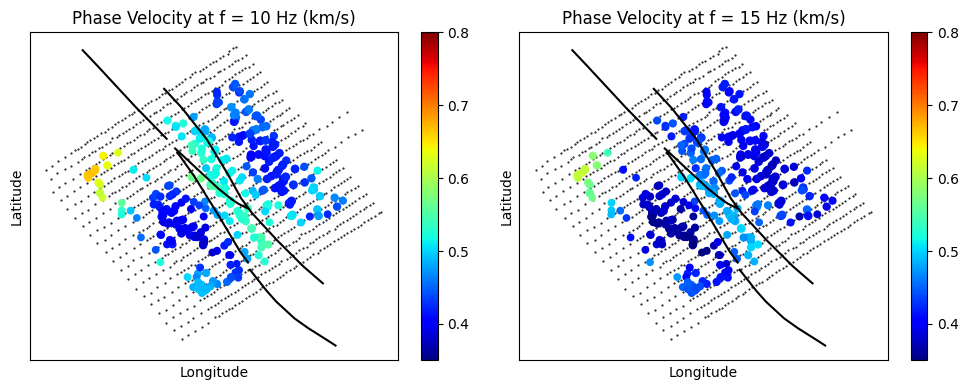

In [38]:
flag_this = 0
c_min = 0.35
c_max = 0.8
flag_num = 1
fig = plt.figure(figsize=(5*len(f_list),4))
for f in f_list:
    
    ax = plt.subplot(1,len(f_list),flag_num)

    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    #im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)
    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size,vmin = c_min,vmax = c_max)
    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)
    plt.colorbar(im,ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')


    flag_num += 1
plt.tight_layout()
print(dir_image+'phase_compare.png')
plt.savefig(dir_image+'phase_compare_2.png',dpi=300)